# Business Objective

Can we predict a customer's spending based on their age, annual income, region, and loyalty score?

-------------------------------------

## Set up and Utilize Dataset ##

In [50]:
# Libraries and Packages
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate

***Load Data***

In [51]:
# --- Ensure consistent working directory for data loading ---
# This block dynamically sets the current working directory to the Git repository root.
# This makes data paths reliable for all collaborators, regardless of where they open the notebook.

current_dir = os.getcwd()
repo_root = current_dir
while not os.path.exists(os.path.join(repo_root, '.git')):
    # Move up one directory
    parent_dir = os.path.dirname(repo_root)
    if parent_dir == repo_root: # Reached filesystem root, .git not found
        raise FileNotFoundError(
            "Could not find the .git directory. "
            "Please ensure you are running this code from within a Git repository."
        )
    repo_root = parent_dir

if os.getcwd() != repo_root:
    os.chdir(repo_root)
    print(f"Working directory set to: {os.getcwd()}") # Informative print for users


# --- Data Loading ---
# Path to the data file, relative to the repository root.
data_file_name = 'df_eng_customer_purchasing_features.csv'
data_file_path = os.path.join( 'data', 'processed', data_file_name)

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded '{data_file_name}'.")
    #print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{data_file_name}' was not found at '{data_file_path}'.")
    print("Please ensure it exists in the 'src/data/' folder relative to the repository root.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

# Create a copy for feature engineering to keep the original data safe
df_LR = df.copy()
print("Original DataFrame shape:", df_LR.shape)

Successfully loaded 'df_eng_customer_purchasing_features.csv'.
Original DataFrame shape: (238, 29)


In [52]:
# Confirm the DataFrame is loaded correctly
df_LR

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency,region_grouped,region_North,region_South,...,is_frequent,is_champion,income_percentile,spending_percentile,growth_potential_score,age_adjusted_percentile,frequency_percentile,log_purchase_amount,log_annual_income,log_purchase_frequency
0,1,25,45000,200,4.5,North,12,North,True,False,...,False,False,0.1408,0.0735,74,0.3333,0-25%,5.2983,10.7144,2.4849
1,2,34,55000,350,7.0,South,18,South,False,True,...,False,False,0.4181,0.2920,100,0.2613,25-50%,5.8579,10.9151,2.8904
2,3,45,65000,500,8.0,West,22,West,False,False,...,False,False,0.6996,0.6702,57,0.1118,50-75%,6.2146,11.0821,3.0910
3,4,22,30000,150,3.0,East,10,North,True,False,...,False,False,0.0042,0.0042,44,0.0196,0-25%,5.0106,10.3090,2.3026
4,5,29,47000,220,4.8,North,13,North,True,False,...,False,False,0.2080,0.0819,100,0.3824,0-25%,5.3936,10.7579,2.5649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,234,40,60000,450,7.2,West,20,West,False,False,...,False,False,0.5441,0.5441,44,0.5586,25-50%,6.1092,11.0021,2.9957
234,235,38,59000,430,6.9,North,20,North,True,False,...,False,False,0.5105,0.4769,59,0.5586,25-50%,6.0638,10.9853,2.9957
235,236,54,74000,630,9.4,South,27,South,False,True,...,True,True,0.9580,0.9580,44,0.8618,75-100%,6.4457,11.2118,3.2958
236,237,32,52000,360,5.8,West,18,West,False,False,...,False,False,0.3046,0.3130,40,0.2613,25-50%,5.8861,10.8590,2.8904


***Verify Data***

In [53]:
# Dataframe Information
print("DataFrame Information:")
df_LR.info()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  238 non-null    int64  
 1   age                      238 non-null    int64  
 2   annual_income            238 non-null    int64  
 3   purchase_amount          238 non-null    int64  
 4   loyalty_score            238 non-null    float64
 5   region                   238 non-null    object 
 6   purchase_frequency       238 non-null    int64  
 7   region_grouped           238 non-null    object 
 8   region_North             238 non-null    bool   
 9   region_South             238 non-null    bool   
 10  region_West              238 non-null    bool   
 11  spend_per_purchase       238 non-null    float64
 12  spend_to_income_ratio    238 non-null    float64
 13  age_group                238 non-null    object 
 14  inc

RMSPE (Root Mean Squared Prediction error) Function

In [54]:
# RMSPE (Root Mean Squared Prediction error) Function
def RMSPE(y_true_var, y_pred_var):
    y_true_var, y_pred_var = np.array(y_true_var), np.array(y_pred_var)
    # Avoid dividing by zero, which will cause an error
    mask = y_true_var != 0
    if not np.any(mask):
        return None
    rmspe = np.sqrt(np.mean(np.square((y_true_var[mask] - y_pred_var[mask]) / y_true_var[mask])))
    return rmspe

------------------------------------------------------------------

# Linear Regression Model 

#### Model Objectives:

Experiment with using the Linear Regression Model, using L1 and L2 Regularization and different optimizers. 

In [55]:
# define the X and Y variables

# headers
X_headers = ['age', 'annual_income', 'loyalty_score',"customer_value_score", "churn_risk_score", "growth_potential_score", "spend_per_purchase"
             ,"spend_to_income_ratio","is_champion", "region_South"]

X = df_LR[X_headers]

y = df_LR['purchase_amount']

In [56]:
# Spliting the data into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

# Create copies of the training and testing datasets for different models
# This ensures that each model utlizes the same training and testing data to ensure the results are comparable.
X_train_Lasso = X_train.copy()
X_train_Ridge = X_train.copy()
X_train_Optimzer = X_train.copy()

X_test_Lasso = X_test.copy()
X_test_Ridge = X_test.copy()
X_test_Optimzer = X_test.copy()

y_train_Lasso = y_train.copy()
y_train_Ridge = y_train.copy()
y_train_Optimzer = y_train.copy()

y_test_Lasso = y_test.copy()
y_test_Ridge = y_test.copy()
y_test_Optimizer = y_test.copy()

In [57]:
# setting up the linear regression model and fitting it with the training data
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [58]:
# Prediction
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSPE:", RMSPE(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 0.0006407499081211171
RMSPE: 6.28398954787841e-05
R² Score: 0.9999999574221855


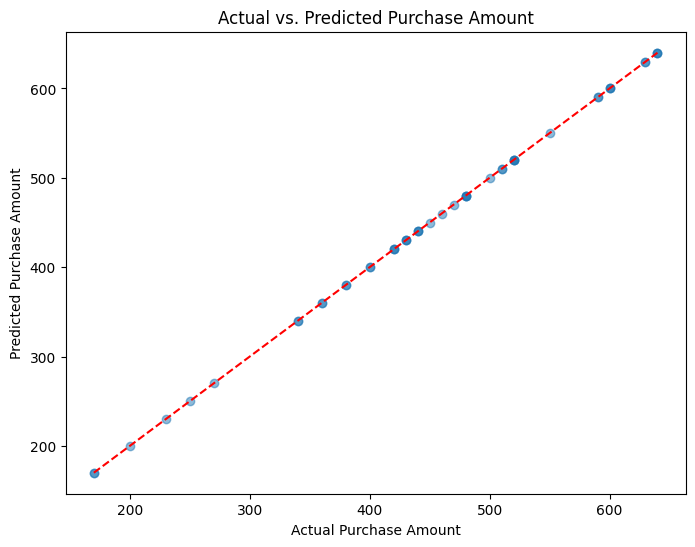

In [71]:
# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Purchase Amount")
plt.ylabel("Predicted Purchase Amount")
plt.title("Actual vs. Predicted Purchase Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

#### Cross Validating The Base Model ####

In [59]:
base_model_CV = cross_validate(
    estimator=model,
    cv=10,  
    X= X_train,
    y= y_train,
    scoring="neg_root_mean_squared_error" 
)

base_model_CV_df = pd.DataFrame(base_model_CV)

base_model_CV_df

,fit_time,score_time,test_score
0,0.005001,0.004001,-0.025655
1,0.005055,0.003001,-0.028084
2,0.005000,0.003001,-0.014046
3,0.003515,0.003003,-0.029629
4,0.005001,0.002999,-0.024127
5,0.005002,0.001998,-0.030960
6,0.004002,0.003001,-0.020343
7,0.003999,0.002999,-0.027278
8,0.004006,0.006995,-0.025515
9,0.005002,0.002999,-0.026737


### L1 - Lasso

In [60]:
# setting up Lasso Model
Lasso_model = Lasso(alpha=0.1)
Lasso_model.fit(X_train_Lasso, y_train_Lasso)

# Prediction
y_pred_Lasso = Lasso_model.predict(X_test_Lasso)

In [61]:
y_pred_Lasso

array([457.95202029, 336.31662409, 600.11615713, 372.2489876 ,
       592.82153028, 399.86466505, 168.8304382 , 516.19617708,
       255.40288852, 349.9762315 , 421.30501034, 592.82153028,
       421.30501034, 444.47744321, 336.31662409, 168.8304382 ,
       408.22530967, 626.34532127, 629.87420303, 232.39914641,
       399.86466505, 349.9762315 , 491.38399736, 600.11615713,
       456.40034187, 408.22530967, 629.87420303, 491.38399736,
       560.98938075, 520.80724751, 521.80159322, 444.47744321,
       421.30501034, 516.19617708, 224.80457955, 521.80159322,
       471.35948735, 270.38610063, 408.22530967, 626.34532127,
       504.50963336, 521.80159322, 600.11615713, 491.38399736,
       629.87420303, 478.44123979, 444.47744321, 372.2489876 ])

In [62]:
print("MSE:", mean_squared_error(y_test_Lasso, y_pred_Lasso))
print("RMSPE:", RMSPE(y_test_Lasso, y_pred_Lasso))
print("R² Score:", r2_score(y_test_Lasso, y_pred_Lasso))

MSE: 56.688141804571465
RMSPE: 0.02335141858678899
R² Score: 0.9962330744730657


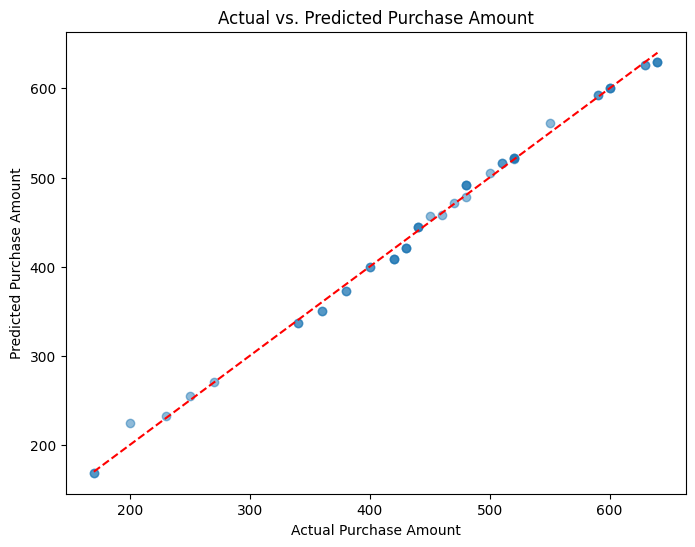

In [72]:
# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_Lasso, alpha=0.5)
plt.xlabel("Actual Purchase Amount")
plt.ylabel("Predicted Purchase Amount")
plt.title("Actual vs. Predicted Purchase Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

#### Cross Validating The Lasso Model ####

In [63]:
lasso_model_CV = cross_validate(
    estimator=Lasso_model,
    cv=10,  
    X= X_train,
    y= y_train,
    scoring="neg_root_mean_squared_error" 
)

lasso_model_CV_df = pd.DataFrame(lasso_model_CV)

lasso_model_CV_df

,fit_time,score_time,test_score
0,0.006001,0.004001,-6.135846
1,0.005462,0.003001,-5.919595
2,0.006315,0.003999,-4.718621
3,0.007000,0.003000,-6.386581
4,0.023003,0.004001,-9.801422
5,0.012003,0.003523,-7.272094
6,0.007989,0.004001,-9.541318
7,0.006001,0.003000,-3.886243
8,0.022005,0.003000,-6.698424
9,0.015004,0.004001,-6.347690


### L2 - Ridge

In [64]:
# L2 Ridge Model

Ridge_Model = Ridge(alpha= 1.0)

Ridge_Model.fit(X_train_Ridge, y_train_Ridge)
Ridge_predictions = Ridge_Model.predict(X_test_Ridge)

In [65]:
Ridge_predictions

array([458.35294603, 336.34267215, 599.94686996, 373.16389726,
       592.61372644, 399.78823993, 169.12468152, 515.82182014,
       255.50510147, 350.24075994, 421.52022241, 592.61372644,
       421.52022241, 444.56972616, 336.34267215, 169.12468152,
       408.43605218, 626.98523392, 630.26590081, 232.22597364,
       399.78823993, 350.24075994, 490.73355464, 599.94686996,
       456.06539768, 408.43605218, 630.26590081, 490.73355464,
       560.64017097, 519.53964268, 521.0486382 , 444.56972616,
       421.52022241, 515.82182014, 222.33008646, 521.0486382 ,
       471.59852349, 270.91851077, 408.43605218, 626.98523392,
       504.66116224, 521.0486382 , 599.94686996, 490.73355464,
       630.26590081, 477.78317581, 444.56972616, 373.16389726])

In [66]:
# Prediction
#y_pred_Ridge = Ridge_Model.predict(X_test_Ridge)

print("MSE:", mean_squared_error(y_test_Ridge, Ridge_predictions))
print("RMSPE:", RMSPE(y_test_Ridge, Ridge_predictions))
print("R² Score:", r2_score(y_test_Ridge, Ridge_predictions))

MSE: 50.86557395175561
RMSPE: 0.021633243606799517
R² Score: 0.9966199839532299


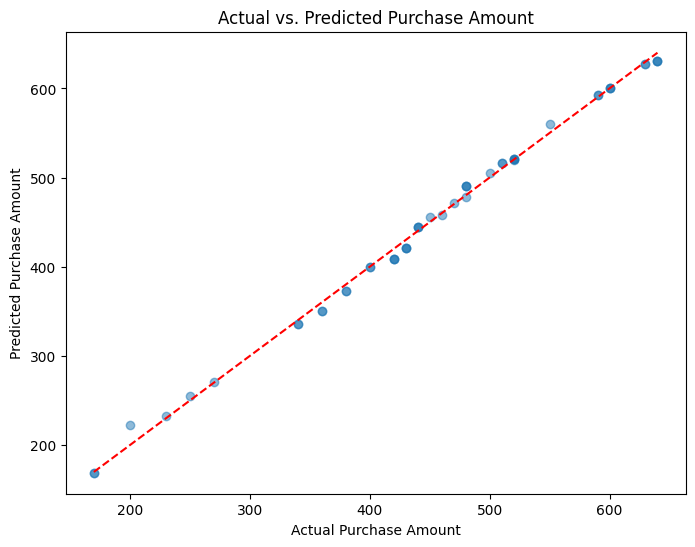

In [73]:
# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, Ridge_predictions, alpha=0.5)
plt.xlabel("Actual Purchase Amount")
plt.ylabel("Predicted Purchase Amount")
plt.title("Actual vs. Predicted Purchase Amount")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

#### Cross Validating The Ridge Model ####

In [67]:
Ridge_model_CV = cross_validate(
    estimator=Ridge_Model,
    cv=10,  
    X= X_train,
    y= y_train,
    scoring="neg_root_mean_squared_error" 
)

Ridge_model_CV_df = pd.DataFrame(Ridge_model_CV)

Ridge_model_CV_df

,fit_time,score_time,test_score
0,0.005001,0.004001,-5.759691
1,0.004000,0.001999,-5.438777
2,0.005003,0.001998,-4.334235
3,0.004000,0.004003,-6.151316
4,0.005000,0.003000,-9.208456
5,0.003001,0.003000,-7.033267
6,0.004916,0.003001,-9.265427
7,0.005003,0.005000,-3.833982
8,0.004000,0.002002,-6.419391
9,0.003000,0.005001,-6.083999


### Optimizers

In [68]:
# Optimizer - SGD
# Initialize and fit SGDRegressor
sgd = SGDRegressor(loss='squared_error', eta0=0.01, max_iter=1000, random_state=38)
sgd.fit(X_train_Optimzer, y_train_Optimzer)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,38


In [69]:
# Prediction
y_pred_Optimizer = sgd.predict(X_test_Optimzer)

print("MSE:", mean_squared_error(y_test_Optimizer, y_pred_Optimizer))
print("RMSPE:", RMSPE(y_test_Optimizer, y_pred_Optimizer))
print("R² Score:", r2_score(y_test_Optimizer, y_pred_Optimizer))

MSE: 7.839025955443538e+35
RMSPE: 2040932451185598.2
R² Score: -5.209030678701662e+31


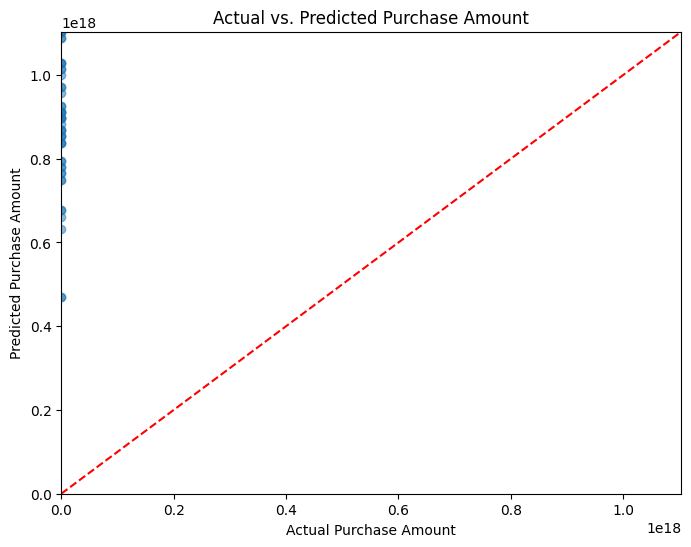

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_Optimizer, alpha=0.5)
plt.xlabel("Actual Purchase Amount")
plt.ylabel("Predicted Purchase Amount")
plt.title("Actual vs. Predicted Purchase Amount")
min_val = min(y_test.min(), y_pred_Optimizer.min())
max_val = max(y_test.max(), y_pred_Optimizer.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.ylim(min_val, max_val)
plt.show()

#### Cross Validating Optimized Model ####

In [70]:
sgd_model_CV = cross_validate(
    estimator=sgd,
    cv=10,  
    X= X_train,
    y= y_train,
    scoring="neg_root_mean_squared_error" 
)

sgd_model_CV_df = pd.DataFrame(sgd_model_CV)

sgd_model_CV_df

,fit_time,score_time,test_score
0,0.007004,0.003000,-2.300906e+18
1,0.006000,0.004001,-3.749250e+17
2,0.006001,0.003000,-1.374239e+18
3,0.008005,0.002998,-2.437162e+18
4,0.008002,0.003000,-1.427392e+18
5,0.006001,0.004000,-4.050434e+18
6,0.006002,0.003002,-4.301971e+18
7,0.005002,0.004002,-3.843614e+18
8,0.005001,0.003001,-3.336556e+18
9,0.006001,0.003002,-9.398507e+17


## Analysis of Results ##



A linear model, utilzing the dataset provide does not seem to be an accurate means to predict spending, based on the results. While linear models can be an efffective and simple solution, the performance metrics suggest that it may not be suitable for this particular data.

When comparing the RMSPE across all the different models. The expectation would be that the RMSPE would have a greater variance between the models and likely be greater than 1%, not below it.

Across the multiple models, each model has a high R² Score. This means that there is not a lot variablity in the predictions and the validation data. 

The high R² Score across the models suggests the possiblity of overfitting. Overfitting means that the model is likely memorizing the data, and is not learning from the underlying patterns of the data. This can impact model's ability to adjust and accurately predict based on new unseen data in a production environment. 

These findings align with the initial exploratory data analysis, which revealed a significant degree of multicollinearity among the features. This further reinforces the possibility that the model is capturing redundant information, leading to artificially high performance during validation but poor generalization. Based on these observations, alternate models may be better suited to answer the main business question.

#### Future Improvements ####

* Create a loop to iteratively run through each model

* However, following big O notation, this increases the computational and storage requirements when trying to evaluate which model to use for production purchases

* Potentially choosing another dataset that is based on the use case, but with data that is more representative and is not synthethic

* Explore hyperparameter tuning the models to see if the models will benefit from this process

* Investigate the optimizer plot graph